In [1]:
# --- Librerías estándar y científicas ---
import numpy as np  # Manipulación de arreglos numéricos de N dimensiones
import matplotlib.pyplot as plt  # Creación de gráficos y visualizaciones
import matplotlib.colors as colors  # Manejo avanzado de mapeos de colores en gráficos
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Control preciso del layout de los ejes en figuras matplotlib
from scipy.optimize import curve_fit  # Ajuste de curvas a funciones definidas
from scipy.spatial import cKDTree
import pandas as pd

# --- Astropy: manejo de datos astronómicos ---
from astropy import units as u  # Manejo de unidades físicas
from astropy.coordinates import SkyCoord, match_coordinates_sky  # Manejo de coordenadas celestes y emparejamiento en el cielo
from astropy.io import fits  # Lectura y escritura de archivos FITS
from astropy.nddata import Cutout2D  # Extracción de recortes 2D de imágenes
from astropy.stats import sigma_clipped_stats  # Estadísticas robustas con eliminación sigma-clipping
from astropy.wcs import WCS  # Manejo de información de coordenadas WCS (World Coordinate System)
from astropy.table import QTable

# --- Photutils: detección y fotometría de fuentes ---
from photutils.detection import DAOStarFinder  # Detección de estrellas usando el algoritmo DAO
from photutils.aperture import CircularAperture, aperture_photometry  # Fotometría mediante aperturas circulares
from photutils.detection import find_peaks

# --- Astroquery: acceso a catálogos astronómicos ---
from astroquery.gaia import Gaia  # Consulta del catálogo Gaia usando ADQL


/home/dcorrea/miniconda3/envs/pip_cont/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Star Finder to PSF

In [3]:
# --- Configuración inicial ---
# Directorios
DIR = ''
OUTPUT_DIR = DIR + 'output/'

# Nombre del archivo fuente
filename = 'Q2038_Muse_Simple_Y.fits'

# --- Lectura del cubo de datos FITS ---
with fits.open(DIR + filename) as hdul:
    cube = hdul[1].data           # Cubo de datos científicos
    vcube = hdul[2].data          # Varianza (para calcular errores)
    header = hdul[1].header       # Encabezado con información WCS

# WCS 2D para coordenadas espaciales
wcs_2d = WCS(header, naxis=2)

# Imagen de luz blanca (suma a lo largo del eje espectral)
white_img = np.nansum(cube, axis=0)
white_img_err = np.sqrt(np.nansum(vcube, axis=0))

# Vector de longitud de onda observado (en Å)
wave_obs = (np.arange(header['NAXIS3']) - (header['CRPIX3'] - 1)) * header['CD3_3'] + header['CRVAL3']

# Espectro total sumando sobre las dos dimensiones espaciales
#spectrum = np.nansum(cube, axis=(1, 2))

# --- Cálculo de límites en coordenadas celestes ---
ny, nx = cube.shape[1:]
corners_x = [0, nx]
corners_y = [0, ny]

# Transformar píxeles de las esquinas a coordenadas RA/Dec
ra_dec = wcs_2d.pixel_to_world([corners_x[0], corners_x[1], corners_x[0], corners_x[1]],
                               [corners_y[0], corners_y[0], corners_y[1], corners_y[1]])

# Límites de la región en grados
ra_min, ra_max = ra_dec.ra.deg.min(), ra_dec.ra.deg.max()
dec_min, dec_max = ra_dec.dec.deg.min(), ra_dec.dec.deg.max()

# --- Consulta ADQL a Gaia ---
# Se usa un límite de magnitud (G < 19) para restringir a estrellas relativamente brillantes
# astrometric_params_solved > 3: buena solución astrométrica
# classprob_dsc_combmod_star > 0.5: probabilidad de ser estrella

query = f"""
SELECT TOP 10
    source_id, ra, dec, phot_g_mean_mag
FROM gaiadr3.gaia_source
WHERE ra BETWEEN {ra_min} AND {ra_max}
  AND dec BETWEEN {dec_min} AND {dec_max}
  AND phot_g_mean_mag < 22
  AND astrometric_params_solved > 3
  AND classprob_dsc_combmod_star > 0.5
ORDER BY phot_g_mean_mag ASC
"""

job = Gaia.launch_job(query)
gaia_results = job.get_results()
print(gaia_results, "\n")


     source_id              ra                dec         phot_g_mean_mag
                           deg                deg               mag      
------------------- ------------------ ------------------ ---------------
6681326648363559168  309.5177334369331  -40.1362220339553       17.584997
6681326751442778880 309.50456576602005 -40.13175964633491       19.382587
6681326545284334976  309.5037111197491 -40.14447419701414       19.573574
6681326549578550272  309.5084255032195 -40.13674770733621       20.061903
6681326648363565568  309.5125923419251 -40.12893437452255       20.072495
6681326515219377536  309.4940062215229 -40.14577757738463        20.75603 



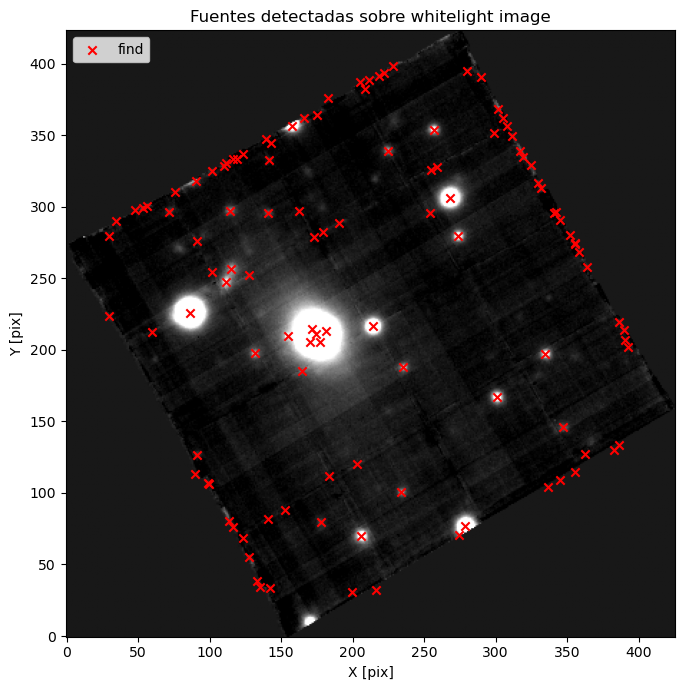

In [4]:

# --- Detección de fuentes con DAOStarFinder ---
# Se usa un umbral de 3 sigma sobre la mediana

mean, median, std = sigma_clipped_stats(white_img, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=3.0 * std)
sources = daofind(white_img - median)

# Coordenadas (x, y) de las fuentes detectadas
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

# --- Filtro para excluir fuentes cerca del borde ---
# Elimina detecciones a menos de X px del borde
MARGIN = 25
inside_mask = (
    (positions[:, 0] > MARGIN) & (positions[:, 0] < nx - MARGIN) &
    (positions[:, 1] > MARGIN) & (positions[:, 1] < ny - MARGIN)
)
positions = positions[inside_mask]

# --- Visualización de la imagen y fuentes detectadas ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))
plt.scatter(positions[:, 0], positions[:, 1], marker='x', color='red', label='find')
plt.title('Fuentes detectadas sobre whitelight image')
plt.xlabel('X [pix]')
plt.ylabel('Y [pix]')
plt.legend(loc="upper left")
plt.grid(False)
plt.tight_layout()
plt.show()


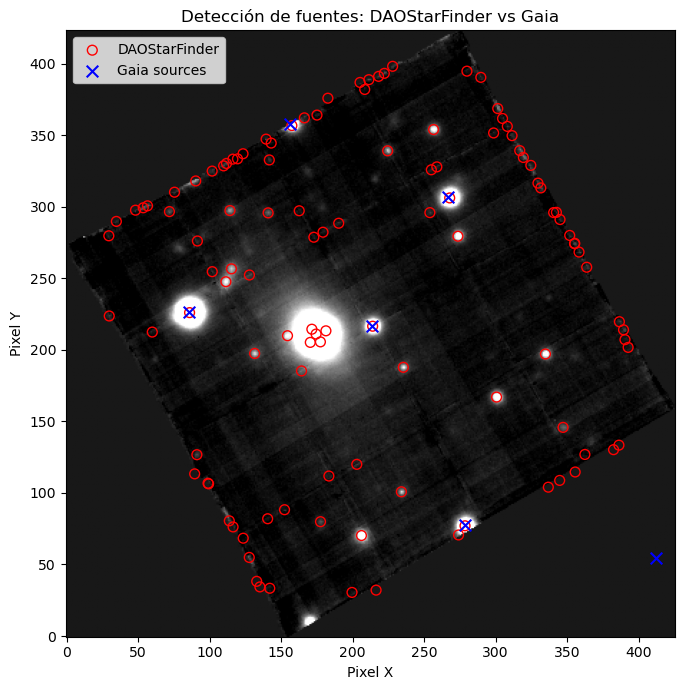

In [14]:
# --- Transformar coordenadas de GAIA (RA, Dec) a píxeles ---

rel_pos_ra, rel_pos_dec = 0,-0.00005 

gaia_coords_corr = SkyCoord(ra=gaia_results['ra']+rel_pos_ra, dec=gaia_results['dec']+rel_pos_dec, unit='deg')
gaia_pixels = wcs_2d.world_to_pixel(gaia_coords_corr)


# --- Mostrar imagen con detecciones DAOStarFinder y Gaia ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))

# Fuentes detectadas por DAOStarFinder (rojo)
plt.scatter(positions[:, 0], positions[:, 1], s=50, edgecolor='red', facecolor='none', marker='o', label='DAOStarFinder')

# Fuentes Gaia transformadas (azul)
plt.scatter(gaia_pixels[0], gaia_pixels[1], s=70, color='blue', marker='x', label='Gaia sources')

plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.title('Detección de fuentes: DAOStarFinder vs Gaia')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Number of matches: 6

Number of clean matches: 3

[[213.98390432 216.60852516]
 [ 85.97590868 226.11631541]
 [267.86362541 306.31000572]]
 ID     img_RA_deg        img_Dec_deg    
--- ------------------ ------------------
  1  309.5084090553333  309.5084090553333
  2 309.51771112410154 309.51771112410154
  3  309.5044939814345  309.5044939814345


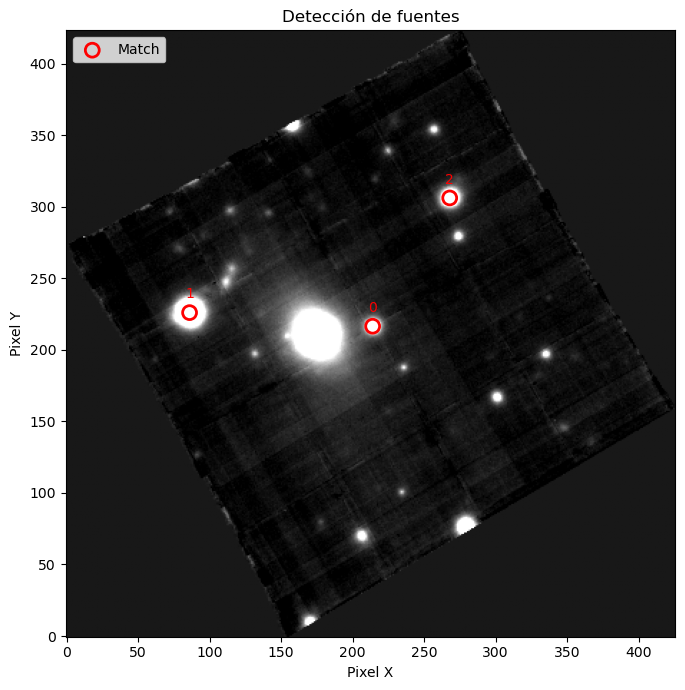

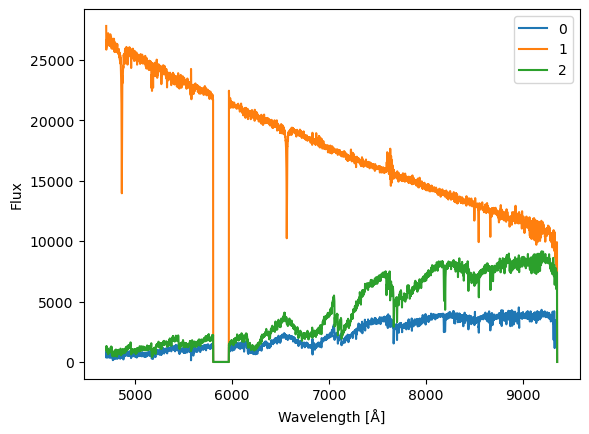

In [16]:
# --- Transformación pixeles a coordenadas celestes (fuentes encontradas) ---
sources_sky_coords = wcs_2d.pixel_to_world(positions[:, 0], positions[:, 1])

# --- Cruce de posiciones con Gaia ---
#gaia_coords = SkyCoord(ra=gaia_results['ra'], dec=gaia_results['dec'], unit='deg')

rel_pos_ra, rel_pos_dec = 0,-0.00005 

gaia_coords_corr = SkyCoord(ra=gaia_results['ra']+rel_pos_ra, dec=gaia_results['dec']+rel_pos_dec, unit='deg')
idx, d2d, _ = match_coordinates_sky(sources_sky_coords, gaia_coords_corr)

# Selecciona coincidencias dentro de 2 arcsec
MATCH_RADIUS = 2.0 * u.arcsec
matched = d2d <= MATCH_RADIUS

print(f"Number of matches: {np.sum(matched)}\n")

# Obtener posiciones y coordenadas coincidentes
matched_positions = positions[matched]
matched_coords = sources_sky_coords[matched]
#stars_coords = np.column_stack((matched_coords.ra.deg, matched_coords.dec.deg))
#print(matched_coords, "\n")
#print(" ")
#matched_coords_gaia = gaia_coords_corr[idx[matched]]
#print(matched_coords_gaia, "\n")


# Usar TODAS las detecciones (positions) para filtrar objetos cercanos
tree_all = cKDTree(positions)
distances, _ = tree_all.query(matched_positions, k=2)  # para cada matched, obtener vecino más cercano
nearest_neighbor_dist = distances[:, 1]

min_sep_pixels = 15  # umbral en píxeles para considerar que una estrella está contaminada
isolated_mask = nearest_neighbor_dist > min_sep_pixels

matched_positions_nocont = matched_positions[isolated_mask]
matched_coords_nocont = matched_coords[isolated_mask]

print(f"Number of clean matches: {len(matched_coords_nocont)}\n")


print(matched_positions_nocont)

# --- Tabla ordenada con los datos emparejados sin contaminacion -- 
matched_table = QTable()
matched_table['ID'] = np.arange(1, np.sum(isolated_mask)+1)
matched_table['img_RA_deg'] = matched_coords_nocont.ra.deg
matched_table['img_Dec_deg'] = matched_coords_nocont.ra.deg
print(matched_table)



# --- Mostrar imagen con detecciones DAOStarFinder y Gaia ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))

# Fuentes detectadas por DAOStarFinder (rojo)
plt.scatter(matched_positions_nocont[:, 0], matched_positions_nocont[:, 1], s=100,linewidths=2, edgecolor='red', facecolor='none', marker='o', label='Match')
for i, (x, y) in enumerate(matched_positions_nocont):
    plt.text(x, y + 10, str(i), color='red', fontsize=10, ha='center')


plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.title('Detección de fuentes')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



# --- Espectros de las estrellas tomadas ---

pixel_scale = 0.2  # arcsec/pixel
aperture_radius_pix = 1 / pixel_scale

for i, pos in enumerate(matched_positions_nocont):
    y, x = int(pos[1]), int(pos[0])
    yy, xx = np.ogrid[:cube.shape[1], :cube.shape[2]]
    mask = (xx - x)**2 + (yy - y)**2 <= aperture_radius_pix**2
    spectrum_obj = np.nansum(cube[:, mask], axis=1)
    plt.plot(wave_obs, spectrum_obj, label=f'{i}')

plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [84]:
#gaia_pixels # gaia_pixels
#matched_positions_nocont # matchedpixels

# PSF and object treatmen


## Metodo artesanal de PSF

In [17]:
# Some useful functions:
# Get an azimuthal-averaged radial profile by using some radial coordinates
def radial_prof(img, rcoord, width=2.0, model=None, check_zeros=True):    
    if check_zeros:
        zeros = img == 0
        img[zeros] = np.nan
        
        if model is not None:
            model[zeros] = np.nan

    rcoord_norm = rcoord // width
        
    r_arr, prof_arr, model_arr = [], [], []
    for r in np.unique(rcoord_norm):            
        sel = rcoord_norm == r
        
        img_sel = img[sel]
        if len(img_sel) < 1:  # just in case only one pixel is selected.
            continue
        
        r_arr.append(r)
        prof_arr.append(np.nanmean(img_sel))
        
        if model is not None:
            model_arr.append(np.nanmean(model[sel]))
        
    if model is None:
        model_arr = np.nan    
    
    return np.array(r_arr), np.array(prof_arr), np.array(model_arr)

# Two-dimensional (circular) Moffat profile
def moffat2D(coord, *params): # params: x0, y0, fwhm, beta, amplitude

    x, y = coord
    x0, y0, amplitude, fwhm, beta, = params

    alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
    r2 = (x - x0)**2 + (y - y0)**2
    model = amplitude / (1 + r2/alpha**2)**beta
    
    return model.ravel()

# 2D Sersic model. Could be useful.
def sersic2D(coord, pars):
    x, y = coord
    x0, y0, PA, Q, I0, Re, n = pars 
    
    xr = (x-x0) * np.cos(PA) + (y-y0) * np.sin(PA)
    yr = -(x-x0) * np.sin(PA) + (y-y0) * np.cos(PA)
    R = np.sqrt(xr**2 + (yr/Q)**2)
    
    bn = 2*n-0.333
    z = I0 * np.exp(-bn * (R/Re)**(1/n))
    
    return z.ravel()

# Fit the lensed qso image. It assumes a moffat2D function is called.
def lens_qso_fit(coord, *params):

    z = np.zeros(np.shape(coord[0])).ravel()
    for i in range(0, len(params), 5):
        
        subparams = params[i:i+5]
        z += moffat2D(coord, *subparams)
        
    #z += sersic2D(coord, params[-7:])
    
    return z

# Auxiliar plot function
def do_imshow_plot(img, mod, res, Npars=0, ncols=3, mask=None, title=None):
    # Ploting cutout image and model
    fig, ax = plt.subplots(ncols=ncols, nrows=1, figsize=(3*ncols,3))

    minval = np.nanmin(img) # to re-scale and not consider negative values
    if mask is not None:
        p = np.nanpercentile(img[mask]-minval, [16, 99.5]) # to normalize color scale
    else:
        p = np.nanpercentile(img-minval, [16, 99.5])
               
    col_norm=colors.LogNorm(vmin=p[0], vmax=p[1])
    
    ax[0].imshow(img-minval, origin='lower', norm=col_norm)
    ax[1].imshow(mod-minval, origin='lower', norm=col_norm)
    
    im = ax[2].imshow(res, origin='lower', vmin=-5, vmax=5, cmap='RdBu_r')
        
    # color bar for residuals
    cax = fig.add_axes([0.69, 0.24, 0.075, 0.025])
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[-5, 0, 5])
    cbar.ax.set_xticklabels([r'-5$\sigma$', '0', r'5$\sigma$'])
    
    # some text
    ax[0].text(0.02, 0.9, 'Star', color='w', transform=ax[0].transAxes)
    ax[1].text(0.02, 0.9, 'Model', color='w', transform=ax[1].transAxes)
    ax[2].text(0.02, 0.9, 'Residuals', color='k', transform=ax[2].transAxes)
    
    if mask is not None:    
        chi2_r = np.nansum(res**2) / (img.size-Npars)      # reduced chi-square value
    else:
        chi2_r = np.nansum(res[mask]**2) / (img[mask].size-Npars)

    ax[1].text(0.6, 0.9, r'$\chi^2_\nu = $'+format(chi2_r,'.5f'), 
                          color='w', 
                          transform=ax[1].transAxes)
    
    if title is not None:
        ax[1].set_title(title)

    for i in range(ncols):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    plt.show()

    return chi2_r

In [18]:
star_radec  = np.column_stack((matched_coords_nocont.ra.deg, matched_coords_nocont.dec.deg))

print(star_radec[-1])

[309.50449398 -40.13183701]


FWHM = 3.4573429322069633       Beta = 1.2472111971545243


/tmp/ipykernel_2123973/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


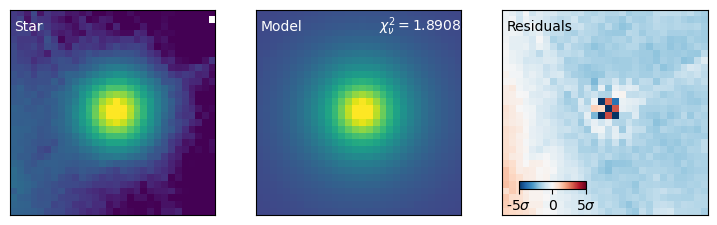

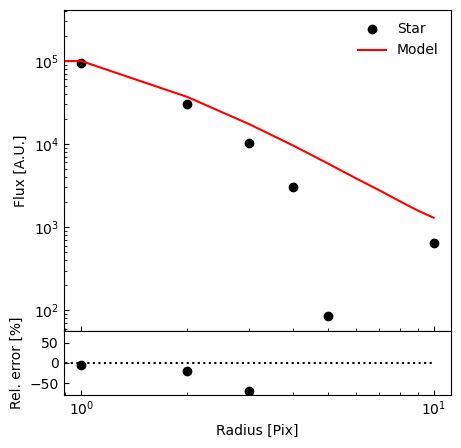

FWHM = 4.474293280991765       Beta = 1.6680944213267273


/tmp/ipykernel_2123973/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


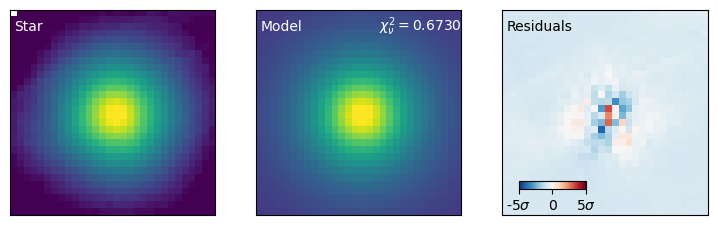

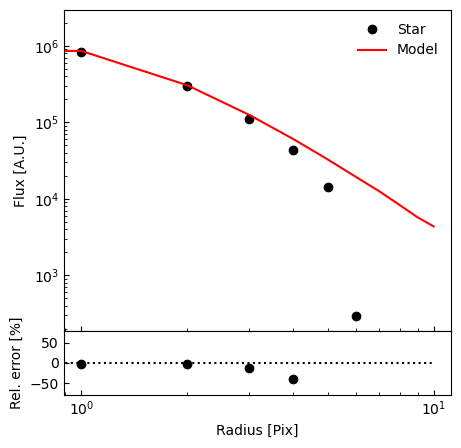

FWHM = 3.835978800644656       Beta = 1.598453356569404


/tmp/ipykernel_2123973/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


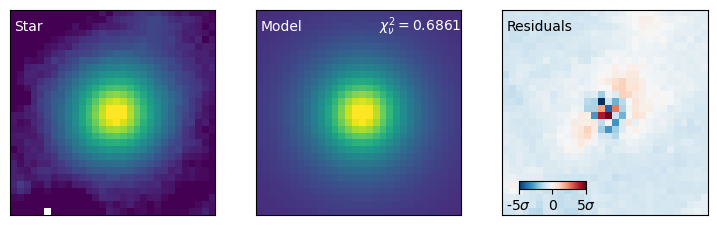

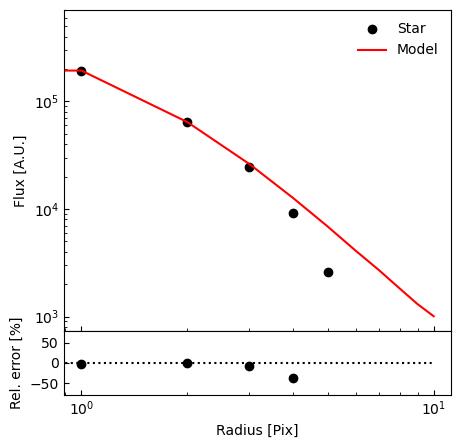

[[3.4573429322069633, 1.2472111971545243], [4.474293280991765, 1.6680944213267273], [3.835978800644656, 1.598453356569404]]


In [19]:
star_radec  = np.column_stack((matched_coords_nocont.ra.deg, matched_coords_nocont.dec.deg))

#star_radec = [star_radec[-1]]


FHMW_Beta_list = []
images_chi2 = []

for i, (ra, dec) in enumerate(star_radec):
    
    # Crear objeto SkyCoord con RA y Dec en grados
    coord = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs')


    # Definir el tamaño del recorte en pixeles
    cutout_size = 30
    #if i == len(star_radec) - 2:
    #    cutout_size = 80


    # Crear recorte en imagen de luz blanca
    cutout = Cutout2D(white_img, coord, size=cutout_size, 
                      wcs=wcs_2d, mode='partial', fill_value=0) 
    cutout_img = cutout.data
    cutout_wcs = cutout.wcs
    del cutout

    # Crear recorte en imagen de error
    aux = Cutout2D(white_img_err, coord, size=cutout_size, 
                   wcs=wcs_2d, mode='partial', fill_value=0) 
    cutout_img_err = aux.data
    del aux

    # -------------------------------------------------------------- #

    # Making the pixel grid that will used during the fit.
    szy, szx = np.shape(cutout_img)
    x, y = np.meshgrid(np.arange(szx), np.arange(szy))

    # One star is at the edge of the datacube, so its cutout 
    # image is filled with zero values for pixels with no data
    # I avoid these pixels in the fit
    # Máscara de píxeles válidos
    no_zeros = cutout_img != 0
    x_aux = x[no_zeros]
    y_aux = y[no_zeros]
    cutout_img_aux = cutout_img[no_zeros]
    cutout_img_err_aux = cutout_img_err[no_zeros]

    # Calculate background statistics for the cutout image and
    # subtract the background. I should add the background 
    # uncertainty to the error budget, but I am *not* doing this.
    
    _, median, std = sigma_clipped_stats(cutout_img_aux, sigma=3.0)

    #std = np.nanstd(cutout_img_aux)

    cutout_img_corr = cutout_img - median
    #cutout_img_aux_corr = cutout_img_aux - median
    
    # Setting the initial guesses and model the star
    guess = [cutout_size/2, cutout_size/2, np.nanmax(cutout_img_corr), 2.2, 4.0]

    popt_psf, pcov_psf = curve_fit(moffat2D, 
                                   (x_aux, y_aux), 
                                   cutout_img_aux.ravel(), 
                                   p0=guess,
                                   absolute_sigma=True, 
                                   sigma=cutout_img_err_aux.ravel())
    

    print("FWHM =", list(popt_psf[3:])[0],"     ","Beta =",list(popt_psf[3:])[1])

        
    FHMW_Beta_list.append(list(popt_psf[3:]))



    # Obtain the best fit. Note that as I am fitting the auxiliar array
    # without zero values, I need to re-arrange the best-fit output to 
    # a 2D array following the cutout image size.
    fit_aux = moffat2D((x_aux, y_aux), *popt_psf)
    fit = cutout_img_corr*0
    fit[no_zeros] = fit_aux
    
    residuals = (cutout_img_corr-fit) / std      # Residuals w.r.t. the image noise

    # Plotting images 
    chi_2 = do_imshow_plot(cutout_img_corr, fit, residuals, Npars=len(popt_psf), 
                                               mask=no_zeros)
    # Extracting radial profiles to provide better comparison
    radius =  np.sqrt((x-popt_psf[0])**2 + (y-popt_psf[1])**2) # circular apertures


    r_prof, img_prof, fit_prof = radial_prof(cutout_img_corr, 
                                             radius, 
                                             model=fit)
    

    images_chi2.append(chi_2)

    # Plotting radial profile
    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.plot(r_prof, img_prof, 'ok', label='Star')
    ax.plot(r_prof, fit_prof, '-r', label='Model')
    
    ax.legend(frameon=False)  
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis="both", direction="in", which='both')

    ax.set_ylabel('Flux [A.U.]')

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="20%", pad=0)


    ax.figure.add_axes(ax2)
        
    ax2.plot(r_prof, 100*(1 - fit_prof/img_prof), 'ok')
    ax2.plot(r_prof, img_prof*0, ':k', linewidth=1.5)

    ax2.set_ylim([-79, 79])
    ax2.set_xscale('log')
    ax2.tick_params(axis="both", direction="in",which='both')
    
    ax2.set_ylabel('Rel. error [%]')
    ax2.set_xlabel('Radius [Pix]')
    
    plt.show()


print(FHMW_Beta_list)

## Fitting del quasar (whitelight image)

In [20]:
# FWHM = [3, 3.3]
# B = [2.19, 3.2]

# Setup lensed qso position 
ra = header.get('CRVAL1')  
dec = header.get('CRVAL2')  
print(ra, dec)

star_psf = FHMW_Beta_list[1]

print(star_psf)
print(2*np.asarray(star_psf))

309.508333 -40.13714
[4.474293280991765, 1.6680944213267273]
[8.94858656 3.33618884]


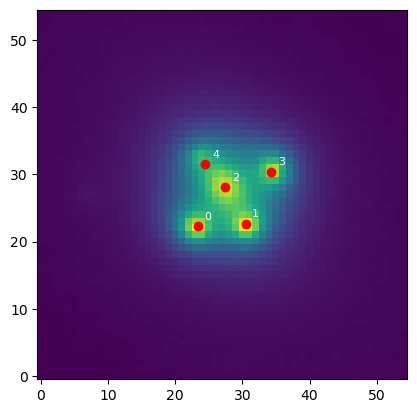

[3.835978800644656, 1.598453356569404]


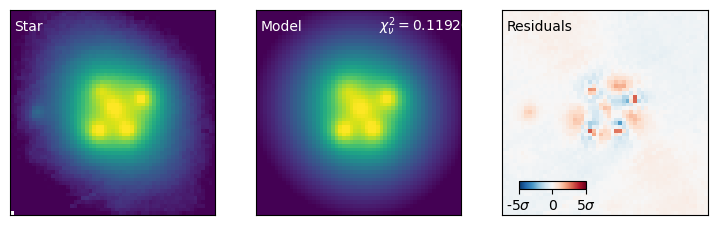

   Fuente          x          y          flujo      FWHM      beta
0       0  23.046910  22.144289  487690.901406  4.417264  1.795511
1       1  30.742248  22.432155  522452.909619  4.792449  1.110540
2       2  27.474204  28.142345  443745.717663  7.200702  1.237744
3       3  34.573719  30.592190  447319.829020  4.646233  1.620057
4       4  24.031679  32.402147  279959.265546  6.295532  1.000474


In [30]:

white_img = np.nansum(cube, axis=0)

ra, dec = 309.5113250, -40.1372073

#y, x = np.ogrid[:white_img.shape[0], :white_img.shape[1]]
#mask = (x - 238)**2 + (y - 251)**2 <= 12**2

#white_img[mask] = np.random.normal(loc=1000, scale=2000)
#white_img[mask] = np.random.normal(loc=-0.375138, scale=14.1206, size=white_img[mask].shape)


#star_psf = list(popt_psf[3:])

# mejores xi2 indice 0 y 4
star_psf = FHMW_Beta_list[1]


coord = SkyCoord(ra, dec, unit='deg', frame='icrs')

# Make cutout for the white-light image and its error image
cutout_size = 55    # in pixel units
cutout = Cutout2D(white_img, coord, size=cutout_size, 
                               wcs=wcs_2d,
                               mode='partial', 
                               fill_value=0) 
qso_img = cutout.data
qso_wcs = cutout.wcs
del cutout

aux = Cutout2D(white_img_err, coord, size=cutout_size,
                                wcs=wcs_2d,
                                mode='partial', 
                                fill_value=0) 
qso_img_err = aux.data
del aux

# Making the pixel grid that will used during the fit.
szy, szx = np.shape(qso_img)
x, y = np.meshgrid(np.arange(szx), np.arange(szy))

# Calculate background statistics for the cutout image and
# find how may sources are within this image. Note that the
# flux threshold used for define a "significant detection" 
# depends on the noise level of the image. Here, I use the
# photutils.find_peaks routine 

mean, median, std = sigma_clipped_stats(qso_img, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=3.0 * std)
sources = daofind(qso_img - median)

xpeak, ypeak, peakval = sources['xcentroid'], sources['ycentroid'], sources['peak']
Nsources = len(xpeak)

plt.imshow(qso_img, origin='lower')  # Checking peaks location
plt.plot(xpeak, ypeak, 'or')
for i in range(len(xpeak)):
    plt.text(xpeak[i] + 1, ypeak[i] + 1, str(i), color='white', fontsize=8)
plt.show()

# Now we prepare the initial guess for the fit. I assume each components 
# are centered at the repective peak location, but I consider some small 
# center mismatch. Similar asumption is made for the peak value. The PSF 
# shape values fixed are by setting very strict lower and upper bounds. 
# I do not like this from a methology point of view, but for this example
# this is good enough. You can use another packages like "lmfit" to do 
# it in properly. 
guess, up_bounds, lo_bounds = [], [], []

print(list(popt_psf[3:]))

#for i in range(Nsources):
#    guess += [xpeak[i], ypeak[i], peakval[i]] + list(star_psf)
#    up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.1*peakval[i]] + [x * 1.00001 for x in star_psf]
#    lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0] + [x * 0.99999 for x in star_psf]
#    print(peakval[i])

for i in range(Nsources):
    guess += [xpeak[i], ypeak[i], peakval[i]] + list(popt_psf[3:])
    
    # Libertad espacial y de intensidad
    up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.5*peakval[i]]
    lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0.1*peakval[i]]
    
    # Libertad del perfil Moffat: FWHM ∈ [1, 10], β ∈ [1.5, 5]
    up_bounds += [20.0, 20.0]
    lo_bounds += [0.5, 1]


# For doing 2D Sersic fit. Not adopted here...
#guess += [szx/2, szy/2, 45, 0.3, np.min(peakval)*0.1, 2, 1]
#up_bounds += [szx/2+10, szy/2+10, 179.9, 0.95, np.min(peakval), 10, 6]
#lo_bounds += [szx/2-10, szy/2-10, 0, 0.05, 0, 0.5, 0.8]

# Do the fit
popt, pcov = curve_fit(lens_qso_fit, 
                       (x, y), 
                       qso_img.ravel(), 
                       p0=guess,
                       sigma=qso_img_err.ravel(),
                       bounds=(lo_bounds, up_bounds))


# Obtain the best fit. Note that the best-fit needs to be re-arranged
# to a 2D array following the cutout image size.
fit = lens_qso_fit((x,y), *popt).reshape(szy,szx)

residuals = (qso_img - fit) / std     # Residuals w.r.t. the image noise

# Plotting images 
do_imshow_plot(qso_img, fit, residuals, Npars=len(popt))



param_list = []
for i in range(Nsources):
    param_list.append({
        "Fuente": i,
        "x": popt[i*5 + 0],
        "y": popt[i*5 + 1],
        "flujo": popt[i*5 + 2],
        "FWHM": popt[i*5 + 3],
        "beta": popt[i*5 + 4]
    })

df = pd.DataFrame(param_list)
print(df)

rangos con parametros libres (no PSF based):  -------   FWHM = [3, 3.3] ------ Beta = [2.19, 3.2] ------

# Go trought wavelenght (Star test)

0


/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


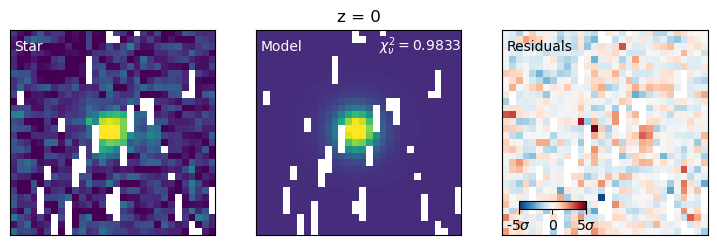

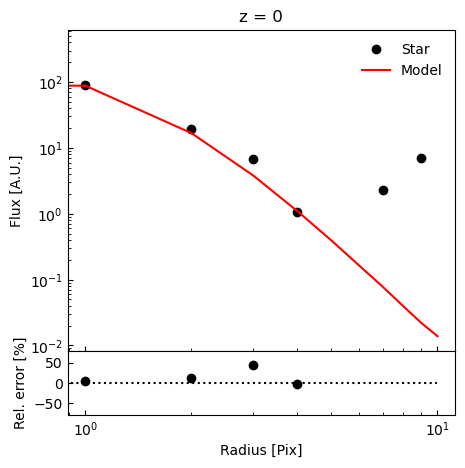

/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: 

600


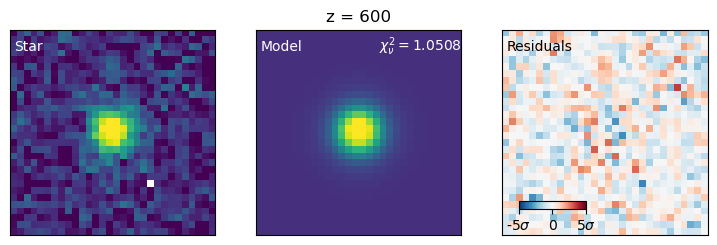

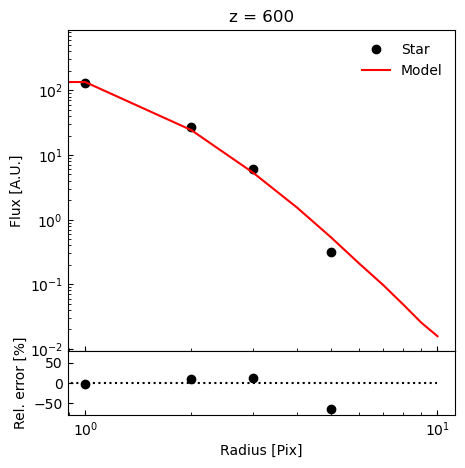

/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: 

1200


/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


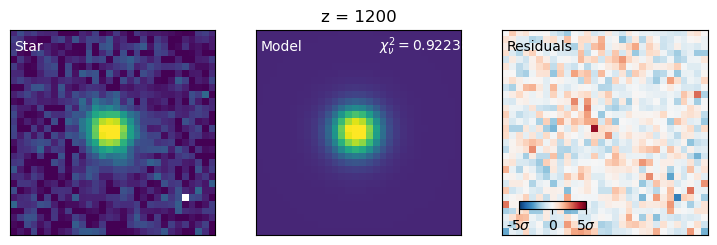

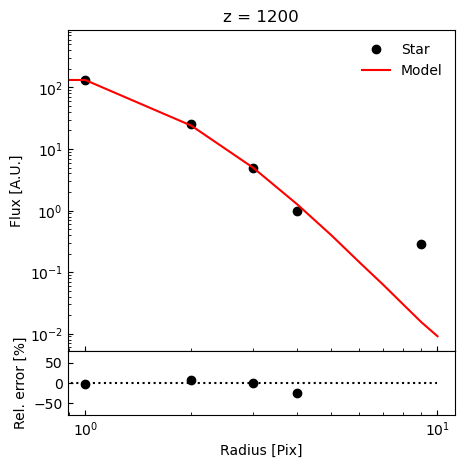

/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: 

1800


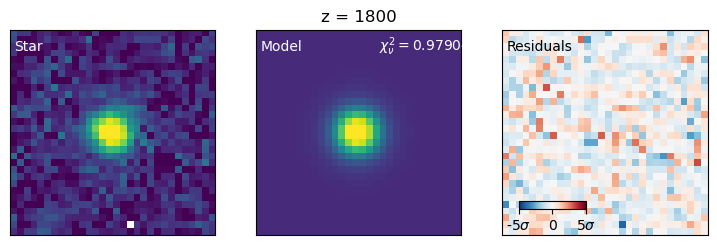

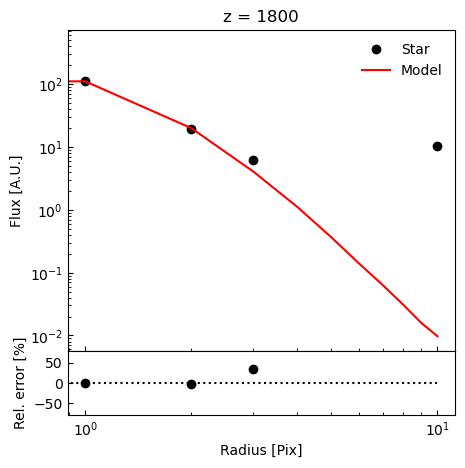

/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: 

2400


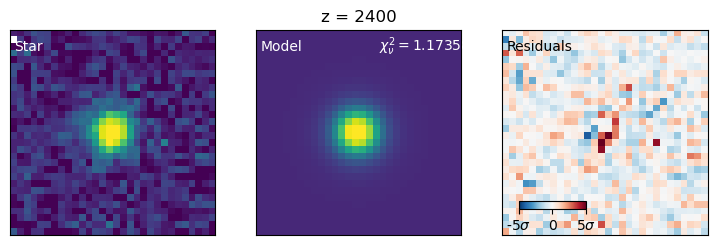

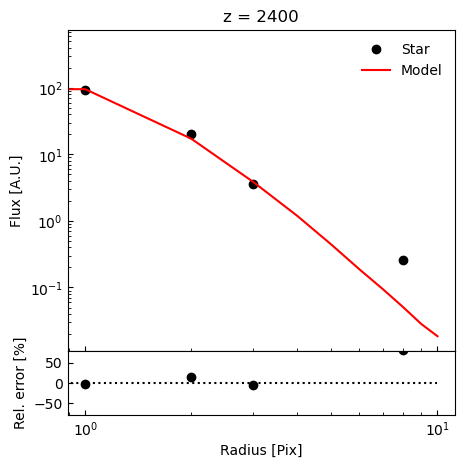

/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: 

3000


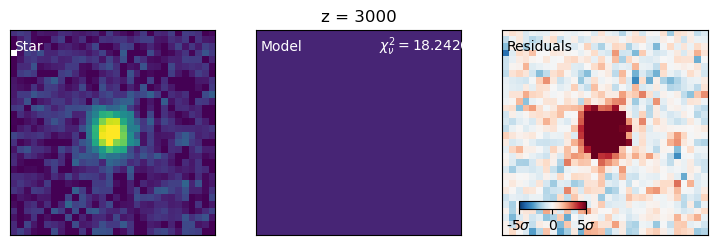

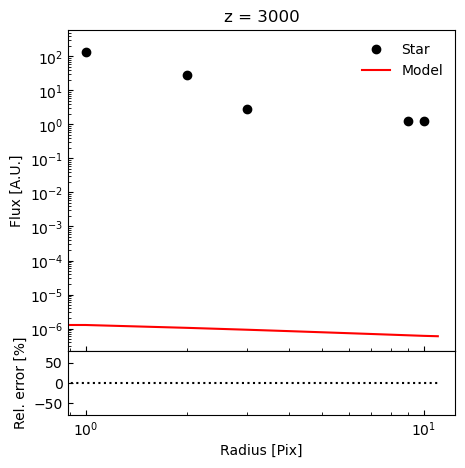

/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: 

3600


/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: overflow encountered in scalar power
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:40: RuntimeWarning: divide by zero encountered in divide
  model = amplitude / (1 + r2/alpha**2)**beta
/tmp/ipykernel_2026859/1470349463.py:85: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_psf, pcov_psf = curve_fit(moffat2D,
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026

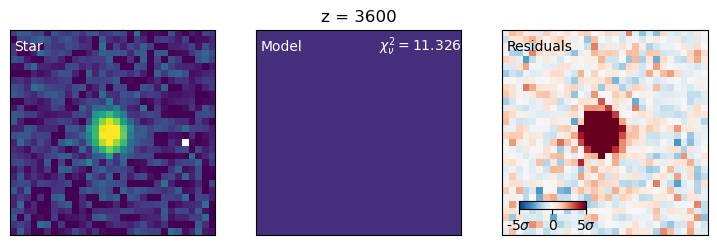

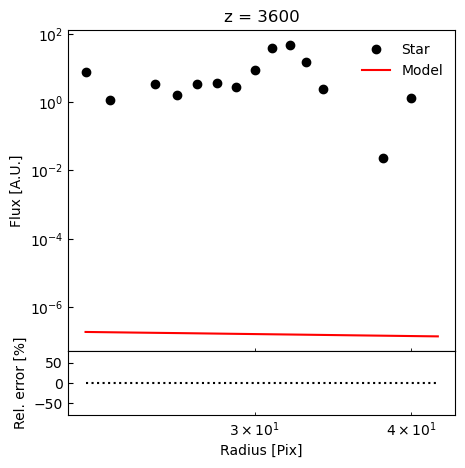

/tmp/ipykernel_2026859/1470349463.py:85: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_psf, pcov_psf = curve_fit(moffat2D,
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: overflow encountered in scalar power
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tmp/ipykernel_2026859/1220232759.py:40: RuntimeWarning: divide by zero encountered in divide
  model = amplitude / (1 + r2/alpha**2)**beta
/tmp/ipykernel_2026859/1470349463.py:85: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_psf, pcov_psf = curve_fit(moffat2D,
/tmp/ipykernel_2026859/1220232759.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
/tm

In [93]:

# Third step: Fitting the star along the MUSE spectral range

# Provide start's coordinates in the astropy's format

star_coord = star_radec[0]

coord = SkyCoord(star_coord[0], star_coord[1], unit='deg', frame='icrs', equinox='J2000')


# Setting cutout size in pixel units 
cutout_size = 30
    
# Making the pixel grid for the cutout image.
# It will be used during the fit.
x, y = np.meshgrid(np.arange(cutout_size), np.arange(cutout_size))

# Setting the initial guesses for the fit
guess = [cutout_size/2, cutout_size/2, 1, 2, 4]

# Doing the fit for each wavelength. This can be customized using
# by modifying the z_fitstep value. I also plot models at some
# wavelengths choosen by specifying the z_plotstep value.
z_fitstep, z_plotstep = 1, 600
par_list = []

np.arange(0, cube.shape[0], z_fitstep)


for k in np.arange(0, cube.shape[0], z_fitstep):
    # with open("z_trace.txt", "a") as f:
    #    f.write(f"{k}\n")


    img = cube[k,:,:]

    if np.all(np.isnan(img)):  # skip fully masked wavelengths
        par_list.append(popt_psf*np.nan)
        continue
    
    # Making cutout image and its error image
    cutout = Cutout2D(img, coord, size=cutout_size,
                                  wcs=wcs_2d,
                                  mode='partial', 
                                  fill_value=0)  
    cutout_img = cutout.data
    cutout_wcs = cutout.wcs
    del cutout
    
    # Making cutout image and its error image
    cutout = Cutout2D(vcube[k,:,:], coord, size=cutout_size,
                                           wcs=wcs_2d,
                                           mode='partial', 
                                           fill_value=0)  
    cutout_img_err = cutout.data
    del cutout

    # Avoiding pixels with 0 or NaN values 
    mask = (cutout_img == 0) | (np.isnan(cutout_img))
    x_aux = x[~mask]
    y_aux = y[~mask]
    cutout_img_aux = cutout_img[~mask]
    cutout_img_err_aux = cutout_img_err[~mask]

    # Calculate background statistics for the cutout image
    # I also subtract the background. I should add the 
    # background uncertainty to the error budget, but I am 
    # *not* doing this.
    _, median, std = sigma_clipped_stats(cutout_img_aux, sigma=3.0)
    cutout_img -= median
    
    # Setting the amplitude's initial guess
    guess[3] = np.nanmax(cutout_img)

    # Doing the fit
    #popt_psf, pcov_psf = curve_fit(moffat2D, 
    #                               (x_aux, y_aux), 
    #                               cutout_img_aux.ravel(), 
    #                               p0=guess,
    #                               sigma=cutout_img_err_aux.ravel())
    
    #par_list.append(popt_psf)
    

    try:
        popt_psf, pcov_psf = curve_fit(moffat2D, 
        (x_aux, y_aux), 
        cutout_img_aux.ravel(), 
        p0=guess,
        sigma=cutout_img_err_aux.ravel(),
        #maxfev=5000
        )
        par_list.append(popt_psf)
    except RuntimeError:
        with open("z_trace.txt", "a") as f:
            f.write(f"Fit failed at index {k}\n")
        par_list.append([np.nan]*len(guess)) 

    if k % z_plotstep == 0:
        print(k)
        fit_aux = moffat2D((x_aux, y_aux), *popt_psf)
        fit = cutout_img*0
        fit[~mask] = fit_aux
        
        resid = (cutout_img-fit) / std      # Residuals w.r.t. the image noise

        # Plotting images 
        do_imshow_plot(cutout_img, fit, resid, Npars=len(popt_psf), 
                                               title='z = '+str(k))

        # Extracting radial profiles to provide better comparison
        radius =  np.sqrt((x-popt_psf[0])**2 + (y-popt_psf[1])**2) # circular apertures
        r_prof, img_prof, fit_prof = radial_prof(cutout_img, 
                                                 radius, 
                                                 model=fit)
    
        # Plotting radial profile
        fig, ax = plt.subplots(figsize=(5,5))
    
        ax.plot(r_prof, img_prof, 'ok', label='Star')
        ax.plot(r_prof, fit_prof, '-r', label='Model')
    
        ax.legend(frameon=False)  
    
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.tick_params(axis="both", direction="in", which='both')

        ax.set_ylabel('Flux [A.U.]')
        ax.set_title('z = '+str(k))

        divider = make_axes_locatable(ax)
        ax2 = divider.append_axes("bottom", size="20%", pad=0)
        ax.figure.add_axes(ax2)
            
        ax2.plot(r_prof, 100*(1 - fit_prof/img_prof), 'ok')
        ax2.plot(r_prof, img_prof*0, ':k', linewidth=1.5)

        ax2.set_ylim([-79, 79])
        ax2.set_xscale('log')
        ax2.tick_params(axis="both", direction="in",which='both')
        
        ax2.set_ylabel('Rel. error [%]')
        ax2.set_xlabel('Radius [Pix]')
        
        plt.show()     


3722


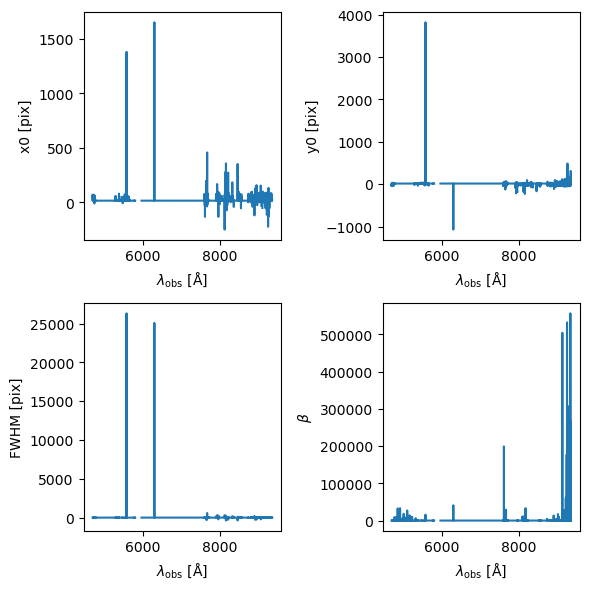

In [77]:
z_arr, par_arr = np.arange(0, np.shape(cube)[0], z_fitstep), np.array(par_list)

#print(np.shape(cube)[0])
print(len(z_arr))


wl_obs = (z_arr - (header['CRPIX3']-1)) * header['CD3_3'] + header['CRVAL3']               
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
   
ax[0,0].plot(wl_obs, par_arr[:,0])
ax[0,0].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[0,0].set_ylabel('x0 [pix]')

ax[0,1].plot(wl_obs, par_arr[:,1])
ax[0,1].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[0,1].set_ylabel('y0 [pix]')


ax[1,0].plot(wl_obs, par_arr[:,3]*0.2)
ax[1,0].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[1,0].set_ylabel('FWHM [pix]')
#ax[1,0].legend(frameon=False)

ax[1,1].plot(wl_obs, par_arr[:,4])
ax[1,1].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[1,1].set_ylabel(r'$\beta$')

fig.tight_layout()
plt.show()

# Go trought wavelenght (QSO)

In [ ]:

white_img = np.nansum(cube, axis=0)

ra, dec = 241.5013, - 23.5567

#y, x = np.ogrid[:white_img.shape[0], :white_img.shape[1]]
#mask = (x - 238)**2 + (y - 251)**2 <= 12**2

#white_img[mask] = np.random.normal(loc=1000, scale=2000)
#white_img[mask] = np.random.normal(loc=-0.375138, scale=14.1206, size=white_img[mask].shape)


#star_psf = list(popt_psf[3:])

# mejores xi2 indice 0 y 4
star_psf = FHMW_Beta_list[0]


coord = SkyCoord(ra, dec, unit='deg', frame='icrs')

# Make cutout for the white-light image and its error image
cutout_size = 55    # in pixel units
cutout = Cutout2D(white_img, coord, size=cutout_size, 
                               wcs=wcs_2d,
                               mode='partial', 
                               fill_value=0) 
qso_img = cutout.data
qso_wcs = cutout.wcs
del cutout

aux = Cutout2D(white_img_err, coord, size=cutout_size,
                                wcs=wcs_2d,
                                mode='partial', 
                                fill_value=0) 
qso_img_err = aux.data
del aux

# Making the pixel grid that will used during the fit.
szy, szx = np.shape(qso_img)
x, y = np.meshgrid(np.arange(szx), np.arange(szy))

# Calculate background statistics for the cutout image and
# find how may sources are within this image. Note that the
# flux threshold used for define a "significant detection" 
# depends on the noise level of the image. Here, I use the
# photutils.find_peaks routine 
mean, median, std = sigma_clipped_stats(qso_img, sigma=3.0)
qso_img -= median  # rough background subtraction

threshold = 5* std                # Threshold for peak detection
tbl = find_peaks(qso_img, threshold, box_size=5)

xpeak, ypeak, peakval = tbl['x_peak'], tbl['y_peak'], tbl['peak_value']
Nsources = len(xpeak)

plt.imshow(qso_img, origin='lower')  # Checking peaks location
plt.plot(xpeak, ypeak, 'or')
for i in range(len(xpeak)):
    plt.text(xpeak[i] + 1, ypeak[i] + 1, str(i), color='white', fontsize=8)
plt.show()

# Now we prepare the initial guess for the fit. I assume each components 
# are centered at the repective peak location, but I consider some small 
# center mismatch. Similar asumption is made for the peak value. The PSF 
# shape values fixed are by setting very strict lower and upper bounds. 
# I do not like this from a methology point of view, but for this example
# this is good enough. You can use another packages like "lmfit" to do 
# it in properly. 
guess, up_bounds, lo_bounds = [], [], []

print(list(popt_psf[3:]))

for i in range(Nsources):
    guess += [xpeak[i], ypeak[i], peakval[i]] + list(star_psf)
    up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.1*peakval[i]] + [x * 1.00001 for x in star_psf]
    lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0] + [x * 0.99999 for x in star_psf]
    print(peakval[i])

#for i in range(Nsources):
    #guess += [xpeak[i], ypeak[i], peakval[i]] + list(popt_psf[3:])
    
    # Libertad espacial y de intensidad
    #up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.5*peakval[i]]
    #lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0.1*peakval[i]]
    
    # Libertad del perfil Moffat: FWHM ∈ [1, 10], β ∈ [1.5, 5]
    #up_bounds += [20.0, 20.0]
    #lo_bounds += [0.5, 1]


# For doing 2D Sersic fit. Not adopted here...
#guess += [szx/2, szy/2, 45, 0.3, np.min(peakval)*0.1, 2, 1]
#up_bounds += [szx/2+10, szy/2+10, 179.9, 0.95, np.min(peakval), 10, 6]
#lo_bounds += [szx/2-10, szy/2-10, 0, 0.05, 0, 0.5, 0.8]

# Do the fit
popt, pcov = curve_fit(lens_qso_fit, 
                       (x, y), 
                       qso_img.ravel(), 
                       p0=guess,
                       sigma=qso_img_err.ravel(),
                       bounds=(lo_bounds, up_bounds))


# Obtain the best fit. Note that the best-fit needs to be re-arranged
# to a 2D array following the cutout image size.
fit = lens_qso_fit((x,y), *popt).reshape(szy,szx)

residuals = (qso_img - fit) / std     # Residuals w.r.t. the image noise

# Plotting images 
do_imshow_plot(qso_img, fit, residuals, Npars=len(popt))



param_list = []
for i in range(Nsources):
    param_list.append({
        "Fuente": i+1,
        "x": popt[i*5 + 0],
        "y": popt[i*5 + 1],
        "flujo": popt[i*5 + 2],
        "FWHM": popt[i*5 + 3],
        "beta": popt[i*5 + 4]
    })

df = pd.DataFrame(param_list)
print(df)